# s29 --  Finite difference approximations to derivatives using centered stencils only with ghost point extrapolationching from ghost cells

In this notebook we hope to assuage the ongoing error introduced from edge differencing to find the derivatives of the distribution function as seen before:

# Motivation

## Fourier (LTE = $O(\Delta z^{22})$) vs. FD corrections (LTE = $O(\Delta z^8)$) DECSKS solvers

## Example 1: bump on tail simulations (short time comparison)

#### Exhibit A: Fourier deriatives show high resolution

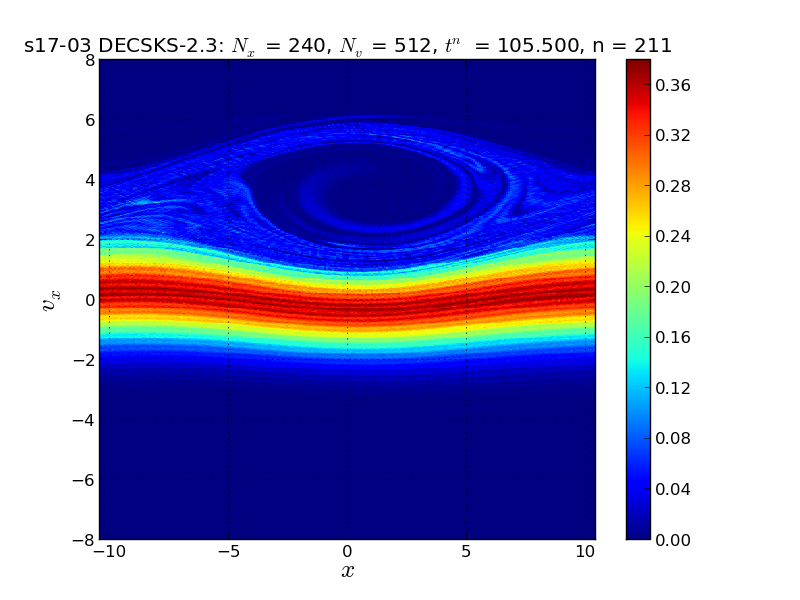

In [2]:
from IPython.display import Image
Image(filename = './fig/s17-03_plot_-_1D1V_electron_O6-4_Nx240Nv512Nt2000_it00211.png')

### Exhibit B: FD corrections with sided differences near the edges to evade off-index referencing from the FD stencils produces high density artifices that originate from the edges that pollute the interior solution

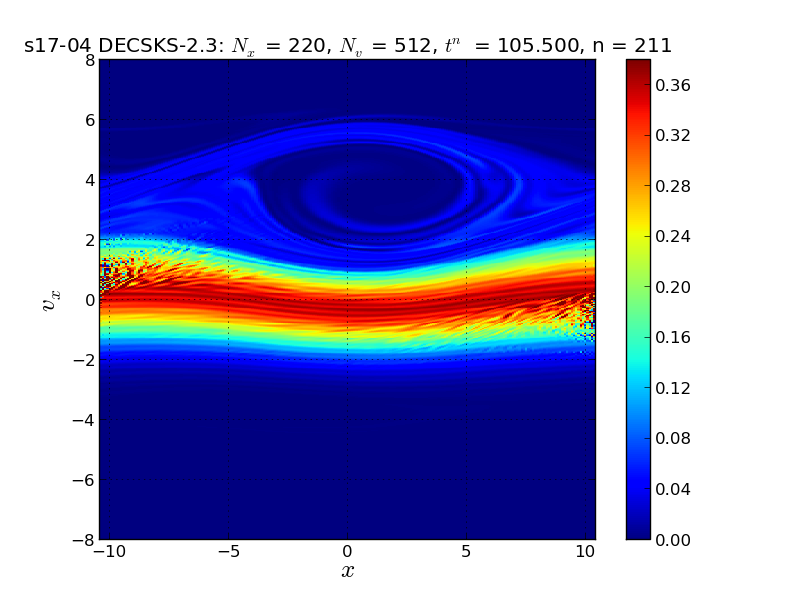

In [70]:
from IPython.display import Image
Image(filename = './fig/s17-04_plot_-_1D1V_electron_O6-4_Nx220Nv512Nt2000_it00211.png')

### Exhibit C: FD corrections using central finite differencing + periodic boundary condition whenever the stencil references off-grid removes the edge errors

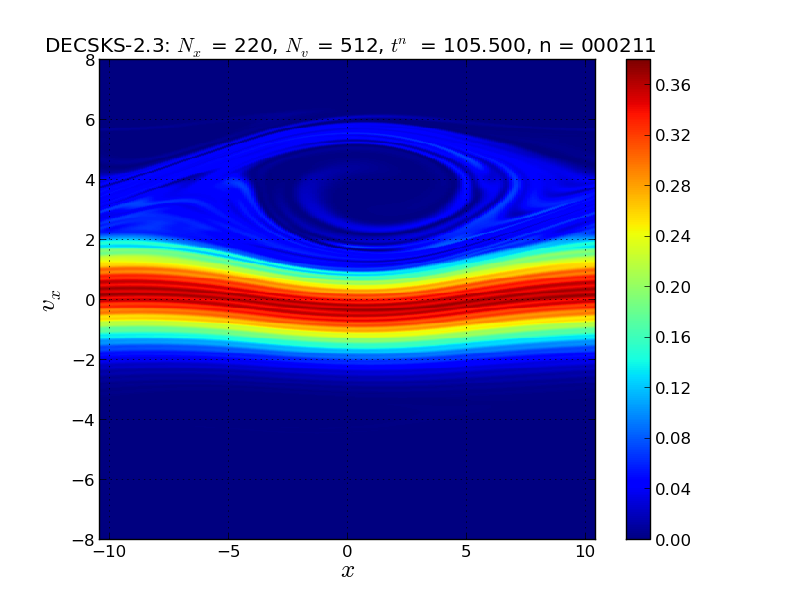

In [1]:
from IPython.display import Image
Image(filename = './fig/s17-04_--_PFD_electron_it000211.png')

Thus, it is clear <font color = "red">there is not something wrong with our FD implementation, there is rather a low fidelity in using sided differencing.</font> <b>We developed the sided differencing scheme to use for boundary problems</b>; however, we see above that it introduces errors!  This notebook aims to assuage these kinds of FD edge errors (which in time contaminate the global solution) by using only central differencing. Since in boundary problems we will not have a periodic boundary condition, we aim to extrapolate as many ghost points as needed in order to use a centered stencil even at edge nodes. The hope is this works out better than sided differencing.

## Example 2: bump on tail simulations (long time comparison)

While we expect modest differences between the solvers (compare exhibits A, C) based on order (FD being 8th order LTE, Fourier being 22nd order LTE), the sided FD differences produces more exaggerated differences that are problematic. The above simulation was long enough to reveal differences, we show a time snapshot much later in the simulation and juxtapose all three simulations again.

### Exhibit A: Fourier corrections

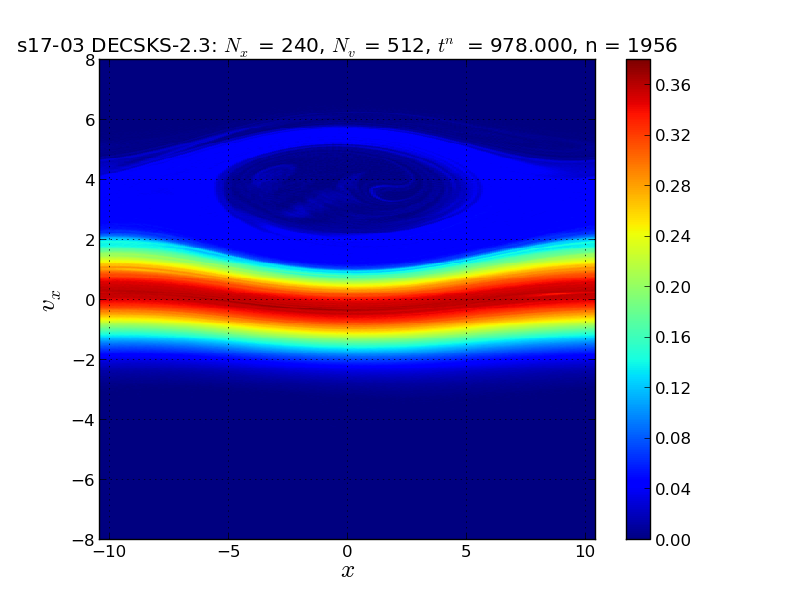

In [2]:
from IPython.display import Image
Image(filename = './fig/s17-03_plot_-_1D1V_electron_O6-4_Nx240Nv512Nt2000_it01956.png')

### Exhibit C: central FD corrections + PBC whenever stencil references off-grid. Compared with the Fourier solution, the solution is "smoothed" out, the some finer filments are not evident in this solution but the global solution only lags by less than one time step ($\Delta t = 0.5$  electron plasma periods)

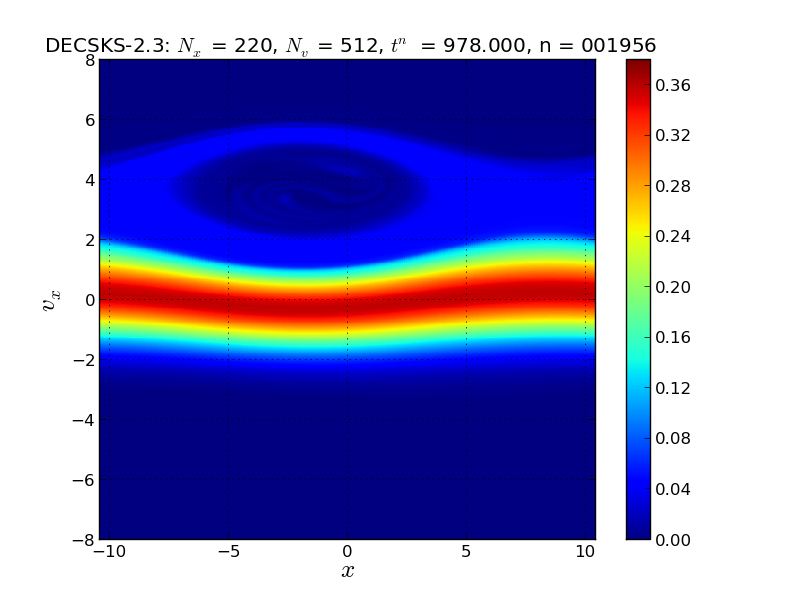

In [5]:
from IPython.display import Image
Image(filename = './fig/s17-04_--_electron_it001956.png')

### Exhibit B: sided FD corrections are significantly phase shifted at the same time compared to the Fourier solution (most trusted given high order, and periodicity permitting spectral-like accuracy)

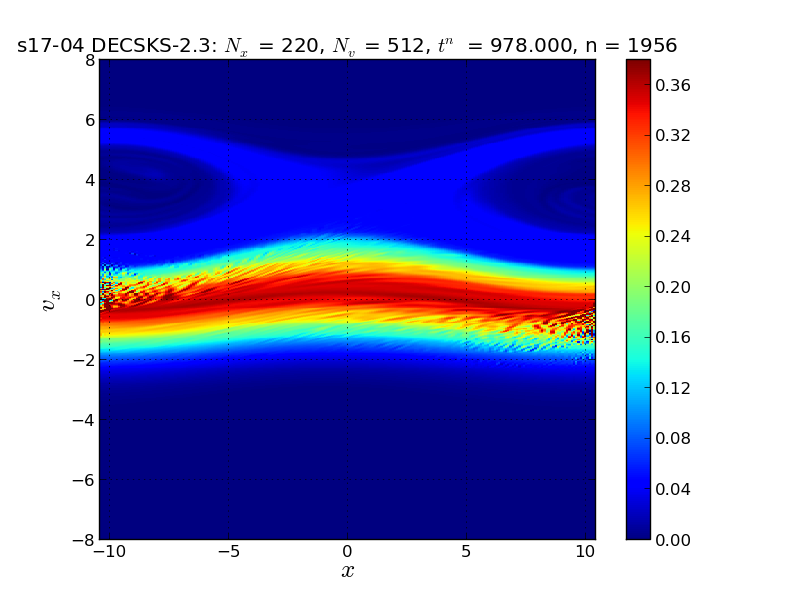

In [4]:
from IPython.display import Image
Image(filename = './fig/s17-04_plot_-_1D1V_electron_O6-4_Nx220Nv512Nt2000_it01956.png')

## Example 3: collector-source problem with sided FD corrections -- the solution is anticipated to be smoother than this

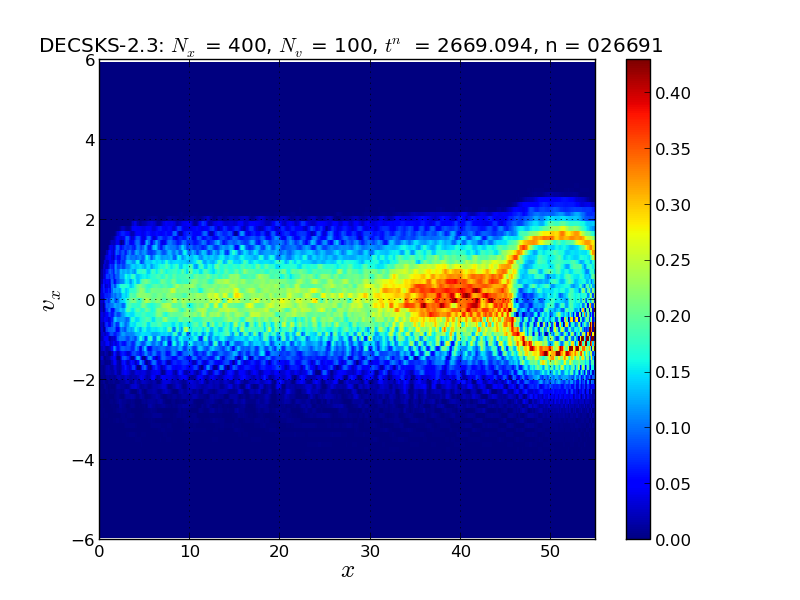

In [4]:
from IPython.display import Image
Image(filename = './fig/s28-01_--_electron_it026691.png')

For a grid as resolved as this, we anticipate a significantly smoother density evolution. While the smoothness may come about if we let the simulation run long enough, this would be lucky rather than correct (and not even very lucky, having longer simulation times to smooth out a solution is the opposite of lucky).

<font color = "red">After we develop and implement the objectives of this notebook, we will run simulation s17-04 again to see a hopeful reduction of the numerical noise</font> that infiltrates the FD solution and hope to see more agreement with the smoother Fourier solution. This FD noise especially in bounded problems is showing significant hampering (at least the FD derivatives are thought to be the culprit). So we hope to achieve better results in the future with this recasted approach. 

# Developing a high order extrapolation prescription

While it sounds initially dangeorus, high order polymomial extrapolation is the <b>same thing</b> as using high order interpolating polynomials to estimate function values outside of the interpolating range. Thus, we develop high order interpolating polynomials and extend our context at the end where we essentially just change names from "inteprolating polynomial" to "extrapolating polynomial." This equivalence is not acknowledged directly enough in literature (derivations of the schemes perhaps are few and far between as well, this author could not find any).

<hr>

We proceed as we can for interpolation at any point, via a Taylor series for a function $f$ expanded about a point $x_P$, where the distance away from this point is the distance of the extrapolant (or interpolant if context fits). Point $P$ just means some point $P$, this can be any point.

$$f(x_j) = \sum_{k = 0}^{s-1} \frac{(x_j - x_P)^k}{k!}\left.\frac{\partial^kf}{\partial x^k}\right|_{x_j} + O(\Delta x^s), \quad j\in \mathbb{Z}$$

It is the above equation along with the following connection that permits us to know the "order" of interpolation / extrapolation, that is we realize the derivatives above can be approximated as usual as

$$\left.\frac{\partial^kf}{\partial x^k}\right|_{x_j} = \left.\frac{\partial^k p_{s-1}(x)}{\partial x^k}\right|_{x_j} + O(\Delta x^s)$$

Where $p_{s-1}$ is an $(s-1)$th order interpolant (e.g. equivalently can be written as a Lagrange interpolating polynomial $L$). e.g.

$$L_{s-1}(x) = \sum_{j=1}^s \ell_j(x)$$

$$\ell_{s-1} (x)= f(x_j)\prod_{\substack{k=1 \\ k \neq j}}^{s} \frac{x - x_k}{x_j - x_k}$$

and we can differentiate these polynomials in general to obtain this expected order of accuracy.

Notice that at $x = x_j$, we have $p_7(x_j) = f(x_j)$ since all terms have in their numerator a term like $(x - x_j)$, except the $j$th term in the sum, which is composed of the product that has the condition $k \neq j$. Thus, all other terms vanish identically.


## Writing a centered Lagrange polynomial

We deice to shift the enumeration in $k = 1, 2, \ldots s$ to be centered (<font color = "red">After note from author: we end up translating to 0-based indexing with an index $m$ after the derivation is complete. It turned out that this initial reindexing to make $j$ centered was inconvenient to implement, thus it was a bad decision. Since the derivation has been typed out for a centered index $j$ we keep it here rather than redo the whole thing in terms of $m$</font>) 

$$k\in \{-\lfloor s/2\rfloor , -\lfloor s/2\rfloor + 1, \ldots , -1, 0, 1, \ldots \lfloor s/2\rfloor - 1, \lfloor s/2 \rfloor\} \quad \text{or} \quad k\in \{-S, -S+1, \ldots , -1, 0, 1, \ldots , S-1, S\}$$

and, consistently we must also have that

$$j\in \{-\lfloor s/2\rfloor , -\lfloor s/2\rfloor + 1, \ldots , -1, 0, 1, \ldots \lfloor s/2\rfloor - 1, \lfloor s/2 \rfloor\} \quad \text{or} \quad j\in \{-S, -S+1, \ldots , -1, 0, 1, \ldots , S-1, S\}$$

<b>We wish to use centered stencils, which can only exist if $s$ is odd $\Rightarrow$ we agree that the following should be used only for odd stencil size</b>. Equivalently, we note that such a stencil size $s$ produces a polynomial of degree $s-1$ which is even, so our extrapolation/interpolating polynomials will all be even.

We write $S \equiv \lfloor s/2\rfloor$ above for brevity and understand since $s$ is agreed upon to be odd then $s = 2S + 1$ (if we used even $s$ then $s = 2S$ and no floor function would be needed) so that a central position exists (defined as there being as many points on either side of such a stencil position).

so, for example if we have $s = 5$, we have $k\in [-S,S]\in\mathbb{Z}$ and in total have $S - (-S) + 1 = 2S + 1 = 2 \lfloor 5 / 2\rfloor + 1 = 2\cdot 2 + 1 = 5$ points in the interpolant. To belabor the point, $s$ odd and we have the relationship:

$$\boxed{s = 2S + 1}\qquad \text{for odd } s \text{ and where } S = \lfloor s/2\rfloor$$

Of course, we also shift the index on $j$ to be consistent, $j\in \{-S, -S+1, \ldots , -1, 0, 1, \ldots , S-1, S\}$

For an $(s-1)$th order polynomial we choose the Lagrange form so $p_{s-1} \equiv L_{s-1}$, we have:

\begin{eqnarray*}
p_{s-1}(x) & = & \sum_{j=-S}^Sf(x_j)\prod_{\substack{k=-S \\ k \neq j}}^{S} \frac{x - x_k}{x_j - x_k}\\
&&
\end{eqnarray*}

Notice the degree of the polynomial is expressed in the product, which contains every term (save one), thus the degree of a polynomial $p_{s-1}$ is $(2S+1) - 1 = 2S$ so we can choose to write $p_{2S}$ if we like (we do so later) or we may write $p_{s-1}$ where $s = 2S + 1$ as noted just prior.

It follows that every denominator for each term $j$ in the sum is a product over $2S$ terms. Every denominator looks similar, and can be written down in a reduced form in general if we take our case of a uniform mesh with width $\Delta x$. 

Take for example one such case where in the above polynomial, suppose we choose a $j$ so that the following product in $k$ in the denominator appears (note this product contains every term except where $k = j$):

$$\text{denominator of } j \text{th term} = (x_j-x_{-S})(x_j-x_{-S+1})\cdot\ldots\cdot(x_j-x_{-1})(x_j-x_{0})(x_j-x_{1})\cdot\ldots\cdot(x_j-x_{S-1})(x_j-x_{S})$$

To understand how this denominator can simplify, take a concrete example, e.g. $j = -S+2$, then we have for $x_i = i\Delta x$, the denominator term in the product of the lagrange polynomial has every such term except the $k = j$ term, which we now say for example is at $j = -S+2$, thus all terms that are in the denominator are as follows:

\begin{eqnarray*}
(x_j - x_{-S})  & =  [(-S+2)-(-S)]\Delta x = &2\Delta x \\
(x_j - x_{-S+1}) & = & [(-S+2)-(-S+1)]\Delta x =& \Delta x \\
&&\\
(\text{there is no } & & k = j = -S+2 \text{ term}) \\
&&\\
(x_j - x_{-S+3})   & = [(-S+2)-(-S+3)]\Delta x=& -\Delta x \\
(x_j - x_{-S+4})   & =  [(-S+2)-(-S+4)]\Delta x =& -2\Delta x \\
(x_j - x_{-S+5})   & = [(-S+2)-(-S+5)]\Delta x = &-3\Delta x \\
(x_j - x_{-S+6})   &=  [(-S+2)-(-S+6)]\Delta x =& -4\Delta x \\
& \vdots &\\
(x_j - x_{-1})   & = [(-S+2) - (-1)]\Delta x =& (-S+3)\Delta x\\
(x_j - x_{0})   & = [(-S+2) - (0)]\Delta x = &(-S+2)\Delta x\\
(x_j - x_{1})   & = [(-S+2) - (1)]\Delta x =& (-S+1)\Delta x\\
(x_j - x_{2})   & = [(-S+2) - (2)]\Delta x = &-S\Delta x\\
(x_j - x_{3})   & = [(-S+2) - (3)]\Delta x = &(-S-1)\Delta x\\
& \vdots &\\
(x_j - x_{S-6})   & = [(-S+2)-(S-6)]\Delta x = &(-2S+8)\Delta x \\
(x_j - x_{S-5})   & = [(-S+2)-(S-5)]\Delta x = &(-2S+7)\Delta x \\
(x_j - x_{S-4})   & = [(-S+2)-(S-4)]\Delta x = &(-2S+6)\Delta x \\
(x_j - x_{S-3})   & = [(-S+2)-(S-3)]\Delta x = &(-2S+5)\Delta x \\
(x_j - x_{S-2})   & = [(-S+2)-(S-2)]\Delta x = &(-2S+4)\Delta x \\
(x_j - x_{S-1})   & = [(-S+2)-(S-1)]\Delta x = &(-2S+3)\Delta x \\
(x_j - x_{S})  & = [(-S+2)-(S)]\Delta x = &(-2S+2)\Delta x \\
\end{eqnarray*}


We can count up the above number of terms as well, we have a total number of terms as $[2 - (-2S+2) + 1] - \underbrace{1}_{j = k \, \text{term}} = 2S$

So we have multiplications like

$$(-2S+2)(-2S+3)(-2S+4)\cdot\ldots\cdot (-S -1)(-S)(-S+1)(-S+2)(-S+3)\cdot\ldots\cdot (-4)(-3)(-2)(-1)(1)(2)(\Delta x)^{2S}$$

in other words, for a general $j = -S+m$, the denominator has terms multiplied from $m$ to $m-1$ to $m-2$ and all such subsequent terms exceptone term which corresponds exactly to $k = j = -S+m$ (i.e. would be $x_j - x_k = 0$) and multiplying all such remaining terms all the way down to the $(-2S+m)$th term, 

<font color = "purple">in informal but simple terms, for $j = -S+m$, the denominator has terms that are multiplication by all integers between $m$ and $-2S+m$ where we skip over the term which causes divison by zero</font>

We work to generalize the denominator term using the above work and considering some specific examples for various $j = -S + m$ for different offsets $m$

## Example set for when $j = -S+m$

We regard the above example for $j = -S + 2$ to piece together quickly the products in one step in the below examples.

<table "width = 95%"><tr><td>
<b>Example 1</b>: $S = \text{ even } = 4$, $m =  \text{ even } = 2$
$${}$$
Then the prefactor in front of $(\Delta x)^{2S}$ is made up of multiplying all numbers between $m = 2$ and $-2S + m = -6$, and skip 0.
$${}$$
$$(2)(1)(-1)(-2)(-3)(-4)(-5)(-6) = [(2)^2 (1)^2 (3)(4)(5)(6)](-1)^6 = [(1)(2)][(1)(2)(3)(4)(5)(6)] = 2! 6! = (-1)^m m! (2S-m)!$$
$${}$$
</td></tr></table>

<table "width = 95%"><tr><td>
<b>Example 2</b>: $S = \text{ even } = 4$, $m =  \text{ odd } = 1$
$${}$$
Then the prefactor in front of $(\Delta x)^{2S}$ is made up of multiplying all numbers between $m = 1$ and $-2S + m = -7$, and skip 0.
$${}$$
$$(1)(-1)(-2)(-3)(-4)(-5)(-6)(-7) = [(1)][(1)(2)(3)(4)(5)(6)(7)](-1)^7 = -1! 7! = (-1)^m m! (2S-m)!$$
$${}$$
</td></tr></table>

<table "width = 95%"><tr><td>
<b>Example 3</b>: $S = \text{ odd } = 5$, $m =  \text{ odd } = 1$
$${}$$
Then the prefactor in front of $(\Delta x)^{2S}$ is made up of multiplying all numbers between $m = 1$ and $-2S + m = -9$, and skip 0.
$${}$$
$$(1)(-1)(-2)(-3)(-4)(-5)(-6)(-7)(-8)(-9) = [(1)][(1)(2)(3)(4)(5)(6)(7)(8)(9)](-1)^9 = -1! 9! = (-1)^m m! (2S-m)!$$
$${}$$
</td></tr></table>

<table "width = 95%"><tr><td>
<b>Example 4</b>: $S = \text{ odd } = 5$, $m =  \text{ even } = 2$
$${}$$
Then the prefactor in front of $(\Delta x)^{2S}$ is made up of multiplying all numbers between $m = 2$ and $-2S + m = -8$, and skip 0.
$${}$$
$$(2)(1)(-1)(-2)(-3)(-4)(-5)(-6)(-7)(-8) = [(2)(1)][(1)(2)(3)(4)(5)(6)(7)(8)](-1)^8 = 2! 8! = (-1)^m m! (2S-m)!$$
$${}$$
</td></tr></table>
<table "width = 95%"><tr><td>
<b>Example 5</b>: $S = \text{ odd } = 5$, $m =  \text{ zero } = 0$
$${}$$
Then the prefactor in front of $(\Delta x)^{2S}$ is made up of multiplying all numbers between $m = 0$ and $-2S + m = -10$, but recall we skip 0, so that we multiply numbers 1 through $-10$, thus we have
$${}$$
$$(1)(-1)(-2)(-3)(-4)(-5)(-6)(-7)(-8)(-9)(-10) = [(1)][(1)(2)(3)(4)(5)(6)(7)(8)(9)(10)](-1)^{10} = 0! 10! =(-1)^m  m! (2S-m)!$$
$${}$$
Since $0!= 1$.
$${}$$
</td></tr></table>
<table "width = 95%"><tr><td>
<b>Example 6</b>: $S = \text{ even } = 6$, $m =  \text{ zero } = 0$
$${}$$
Then the prefactor in front of $(\Delta x)^{2S}$ is made up of multiplying all numbers between $m = 0$ and $-2S + m = -12$, but recall we skip 0, so that we multiply numbers 1 through $-12$, thus we have
$${}$$
$$(1)(-1)(-2)(-3)(-4)(-5)(-6)(-7)(-8)(-9)(-10)(-11)(-12) = [(1)][(1)(2)(3)(4)(5)(6)(7)(8)(9)(10)(11)(12)](-1)^{12} = 0! 10! = (-1)^m m! (2S-m)!$$
$${}$$
Since $0!= 1$.
$${}$$
</td></tr></table>

Finally, note that every number <b>note that any point $j$ can be written as $j = -S+m$</b> where $m\in\{0, 1, 2, \ldots 2S\}$, thus the denominator term expression is general for $s$ odd, we have $S = \lfloor s/2\rfloor$ where 

$$\text{denominator } = (-1)^m m!(2S-m)!(\Delta x)^{2S} \qquad \text{for } s \text{ odd}$$

Finally, note that $j = -S + m \Rightarrow m = j + S$, so $2S-m = 2S  - j - S = S - j$ and $m! = (j+S)!$, so we have

$$\text{denominator } = (-1)^{j+S} (S+j)!(S-j))!(\Delta x)^{2S} \qquad \text{for } s \text{ odd}$$

Now that the form is written like this, it suggests there was an easier way to derive this. Anyway, 

for uniform spacing we have the special definition of the Lagrange polynomial:

$$\boxed{p_{s-1}(x) \equiv p_{2S}(x)=   \frac{1}{(\Delta x)^{2S}}\sum_{j=-S}^S f(x_j)\frac{(-1)^{S+j}}{(S+j)!(S-j)!}\prod_{\substack{k=-S \\ k \neq j}}^{S} (x - x_k)} \qquad \text{for } s \text{ odd}$$


## Example: $s = 3 \Rightarrow p_2(x)$

We use the derived formula for a quadratic polynomial to see if we get the expected polynomial.


We have $s = 3, s-1 = 2, S = \lfloor s/2\rfloor = 1$, then the above formula becomes:

\begin{eqnarray*}
p_{s-1}(x) & = &  \frac{1}{(\Delta x)^{2S}}\sum_{j=-S}^S f(x_j)\frac{(-1)^{S+j}}{(S+j)!(S-j)!}\prod_{\substack{k=-S \\ k \neq j}}^{S} (x - x_k) \\
&&\\
p_{2}(x) & = &  \frac{1}{(\Delta x)^{2}}\sum_{j=-1}^1 f(x_j)\frac{(-1)^{1+j}}{(1+j)!(1-j)!}\prod_{\substack{k=-1 \\ k \neq j}}^{1} (x - x_k) \\
 & = &  \frac{1}{(\Delta x)^{2}} f(x_{-1})\frac{(-1)^{1+{-1}}}{(1+(-1))!(1-(-1))!}\prod_{\substack{k=-1 \\ k \neq {-1}}}^{1} (x - x_k) \\ 
&& +  \frac{1}{(\Delta x)^{2}}f(x_{0})\frac{(-1)^{1+{0}}}{(1+{0})!(1-{0})!}\prod_{\substack{k=-1 \\ k \neq {0}}}^{1} (x - x_k) \\
&& +\frac{1}{(\Delta x)^{2}} f(x_{1})\frac{(-1)^{1+{1}}}{(1+{1})!(1-{1})!}\prod_{\substack{k=-1 \\ k \neq {1}}}^{1} (x - x_k) \\
&&\\
p_2(x)  & = &  \frac{1}{2(\Delta x)^{2}} f(x_{-1})(x - x_0)(x - x_1) + \frac{1}{(\Delta x)^{2}} f(x_0)(x - x_{-1})(x - x_1) \\ 
&& + \frac{1}{2(\Delta x)^{2}} f(x_1)(x - x_{-1})(x - x_0) \checkmark \\ 
\end{eqnarray*}

This is what a centered Lagrange polynomial looks like. For example, the reader can easily show that $p_2(x_{-1}) = f(x_{-1})$, $p_2(x_{0}) = f(x_{0})$, and $p_2(x_{1}) = f(x_{1})$

# General derivatives of an $(s-1)$th degree centered Lagrange polynomial

It is tempting to take a side step here to derive general forms of derivatives. The utility of this could be, for example, to have an easy formula for computing the finite difference coefficients of a scheme.

We do this in steps, by considering a couple derivatives then generalize.

Differentiating $p_{s-1}(x) \equiv p_{2S}(x)=   \frac{1}{(\Delta x)^{2S}}\sum_{j=-S}^S f(x_j)\frac{(-1)^{S+j}}{(S+j)!(S-j)!}\prod_{\substack{k=-S \\ k \neq j}}^{S} (x - x_k)$ (where $s$ is odd) once is easy:


\begin{eqnarray*}
\frac{\partial p_{s-1}(x)}{\partial x} & = & \frac{\partial}{\partial x}\frac{1}{(\Delta x)^{2S}}\sum_{j=-S}^S f(x_j)\frac{(-1)^{S+j}}{(S+j)!(S-j)!}\prod_{\substack{k=-S \\ k \neq j}}^{S} (x - x_k)\\
&& \\
& = & \frac{1}{(\Delta x)^{2S}}\sum_{j=-S}^S f(x_j)\frac{(-1)^{S+j}}{(S+j)!(S-j)!}\frac{\partial}{\partial x}\prod_{\substack{k=-S \\ k \neq j}}^{S} (x - x_k)\\
&&\\
& = & \frac{1}{(\Delta x)^{2S}}\sum_{j=-S}^S f(x_j)\frac{(-1)^{S+j}}{(S+j)!(S-j)!}\left[\sum_{\substack{\ell = -S \\ \ell \neq j}}^S  \frac{\partial}{\partial x}(x - x_{\ell})\prod_{\substack{k=-S \\ k \neq j \\ k \neq \ell}}^{S} (x - x_k)\right]
&& \\
\end{eqnarray*}

which gives

$$\boxed{\frac{\partial p_{s-1}(x)}{\partial x}  =  \frac{1}{(\Delta x)^{2S}}\sum_{j=-S}^S f(x_j)\frac{(-1)^{S+j}}{(S+j)!(S-j)!}\left[\sum_{\substack{\ell = -S \\ \ell \neq j}}^S\prod_{\substack{k=-S \\ k \neq j \\ k \neq \ell}}^{S} (x - x_k)\right]}$$

The reader can verify a simple example, e.g. $s = 3$ produces the quadratic $s-1 = 2$ polynomial:

$$\frac{\partial p_s}{\partial x} = \frac{1}{2(\Delta x)^2}f_{-1}[(x-x_1) + (x-x_0)] - \frac{1}{(\Delta x)^2} f_0 [ (x - x_1) + (x - x_{-1})] + f_1 \frac{1}{2(\Delta x)^2}[ (x - x_0) + (x - x_{-1})]$$

where for example, evaluating at $x = x_0$, we recover $p_2'(x_0) = \frac{1}{2\Delta x}(f_1 - f_{-1})$ (central difference approximation for the first derivative, $O(\Delta x^2)$). Additionally, we can also recover the schemes, e.g. $p_2'(x_{-1}) = \frac{1}{\Delta x} [ \frac{3}{2}f_{-1} + 2f_0 - \frac{1}{2}f_1]$ which is the forward difference approximation for the first derivative. Similarly, the backward difference can be recovered by evaluation at $x = x_1$.

We show some more derivatives for instructional value, and produce the generalization for reference.

Taking a second derivative is also easy:

\begin{eqnarray*}
\frac{\partial^2 p_{s-1}(x)}{\partial x^2}  & = & \frac{\partial}{\partial x}\frac{\partial p_{s-1}(x)}{\partial x} \\
& = & \frac{\partial}{\partial x}\frac{1}{(\Delta x)^{2S}}\sum_{j=-S}^S f(x_j)\frac{(-1)^{S+j}}{(S+j)!(S-j)!}\left[\sum_{\substack{\ell = -S \\ \ell \neq j}}^S\prod_{\substack{k=-S \\ k \neq j \\ k \neq \ell}}^{S} (x - x_k)\right]\\
&&\\
\frac{\partial^2 p_{s-1}(x)}{\partial x^2}  & = & \frac{1}{(\Delta x)^{2S}}\sum_{j=-S}^S f(x_j)\frac{(-1)^{S+j}}{(S+j)!(S-j)!}\left[\sum_{\substack{m = -S \\ m \neq j}}^S\sum_{\substack{\ell = -S \\ \ell \neq j \\ \ell \neq m}}^S\prod_{\substack{k=-S \\ k \neq j \\ k \neq \ell \\ k \neq m}}^{S} (x - x_k)\right]
\end{eqnarray*}

Taking a $q$th derivative is also straightforweard, we drop the brackets for aesthetics (and because they are unnecessary):

### General derivative $q \leq s-1$ of a centered Lagrange interpolating polynomial $p_{s-1}$ of degree $(s-1)$ 

$$\boxed{\frac{\partial^q p_{s-1}(x)}{\partial x^q}   = \frac{1}{(\Delta x)^{2S}}\sum_{j=-S}^S f(x_j)\frac{(-1)^{S+j}}{(S+j)!(S-j)!}\sum_{\substack{q = - S \\ q \neq j}}\cdots\sum_{\substack{n = -S \\ n \neq j \\ \vdots \\ n \neq q}}^S\sum_{\substack{m = -S \\ m \neq j \\ m \neq n \\ \vdots \\ n \neq q}}^S\sum_{\substack{\ell = -S \\ \ell \neq j \\ \ell \neq m \\ \ell \neq n \\ \vdots \\ \ell \neq q}}^S\prod_{\substack{k=-S \\ k \neq j \\ k \neq \ell \\ k \neq m \\ k \neq n \\ k \neq m \\ \vdots \\ k \neq q}}^{S} (x - x_k)}$$


# Application to extrapolation

Recall,

$$\boxed{p_{s-1} \equiv p_{2S}(x) =   \frac{1}{(\Delta x)^{2S}}\sum_{j=-S}^S f(x_j)\frac{(-1)^{S+j}}{(S+j)!(S-j)!}\prod_{\substack{k=-S \\ k \neq j}}^{S} (x - x_k)} \qquad \text{for } S \geq 1\in\mathbb{N}$$

(Where the obscured constraint that was obvious earlier and now hidden is that the stencil size $s = 2S+1$ is odd, this is the only way such a sum can have a centered stencil).

<b>We can choose any stencil size, say by choosing the half-width $S \geq 1$ and use this to extrapolate as many ghost points. But, the question of this section is <font color = "purple">how many ghost points are "needed"?</font></b>. 

Answer: first we need to understand that ghost points are needed so that we can use a centered stencil for finite difference estimates of derivatives for every gridpoint; the edge nodes will require sampling off-grid (at the ghost points). <b>The size of the largest stencil for a derivative required indicates how many ghost points we need</b>. The stencil size of each derivative of order $q$ depends on the needed LTE order $p$ (stencil size = $p+q$ for explicit finite differencing schemes as we do). It turns out (and this is old news, cf. prelim) that we require terms that look like $(\Delta x)^q \partial_x^q f$, not just the derivative. These grouped terms need to have an LTE order $N+1$ so that the global error is $N$ over a full simulation. Thus, as $q$ increases, the requirement on $p$ (LTE) decreases. It turns out that this produces a stencil size $ = p + q = N+1 = \text{constant}$, so that <b>all stencil sizes for every derivative needed turns out to be same and $= N+1$</b>. 

Finally, as stated <b>we want to use centered differencing</b>, thus we <b>need an odd number stencil</b> so that equal number of point will be sampled to the left and right of the stencil position $0$. <b>This amounts to $N+1$ being odd, or equivalently that $N$ be even</b>. This guarantees that all our derivative stencils will have a centered scheme that exists (odd numbered stencil), and we can finally also conclude that the number of ghost points needed will be $N/2$ if we choose $N$ even and use a centered stencil. This is the maximum off-grid data needed as determined by considering central differencing the first or last gridpoint, the full half-width of the stencil, $N/2$ reaches outside the domain.

We go through some examples below to prove this if the above discussion was too esoteric. Before we do so though, we note <font color = "green">in all previous FD corrections-based DECSKS simulations we have been using a global error order 7. Since this is an odd number, <b>we will choose to downgrade to order $N = 6$ for FD-based DECSKS simulations with the intention of using centered stencils for all derivatives, thus we need 6/2 = 3 ghost points on the distribution functions</font></b>

#### <font color = "red">Examples to prove the above discussion on needing $N$ even and that $N/2$ ghost points are needed</font>

(the reader who finds the above clear can skip this section without loss of continuity)

For a global error $N$  (LTE error $N+1$) we require $N-1$ derivatives, and the order of accuracy of these derivatives must taper off with the incremental (i.e. we correct it to higher order summatively, one by one).

We must have (see for example, prelim p.68; terse reminder: this is because the correction terms show up as powers $(\Delta x)^q\partial_x^qf$ rather than with the derivatives themselves, so the accuracy requirement on the derivative decreases with increasing derivative number to get the same $O(\Delta x^{N+1})$ needed in the LTE of the scheme at each step):

$$\text{LTE}\left(\frac{\partial^q f}{\partial x^q}\right) = O(\Delta x ^{N+1 - q})$$

For $N$ odd, say $N = 3$, we would need $q = 1,2$ derivatives with orders

$$\text{LTE}\left(\frac{\partial f}{\partial x}\right) = O(\Delta x ^{3+1 - 1})= O(\Delta x ^{3})$$

and

$$\text{LTE}\left(\frac{\partial^2 f}{\partial x^2}\right) = O(\Delta x ^{3+1 - 2})= O(\Delta x ^{2})$$

for our stencils on the derivatives of the required order $p$, we would need

for $q = 1$ derivative, stencil size = $q + p = 1 + 3 = 4$

for $q = 2$ derivative, stencil size = $q + p = 2 + 2 = 4$

Thus, the stencil is always the same size for all derivatives so it conveniently suffices that a restriction on $s$ is a restriction on $N$,. This stencil has an even number, we can see that if we choose $N$ even, we get the needed odd numbered stencil (reminder: we derived the case above for odd number stencils so that $i = 0$ could always serve as a center with $\lfloor s / 2 \rfloor$ gridpoint samples on either side, having a stencil like this is able to kill off an extra order by virtue of the centered stencil as is well known and hence is the motivation).

<hr>

For $N$ even, say $N = 4$, we would need $q = 1,2,3,4$ derivatives with orders

$$\text{LTE}\left(\frac{\partial f}{\partial x}\right) = O(\Delta x ^{4+1 - 1}) = O(\Delta x ^{4})$$

$$\text{LTE}\left(\frac{\partial^2 f}{\partial x^2}\right) = O(\Delta x ^{4+1 - 2})= O(\Delta x ^{3})$$

$$\text{LTE}\left(\frac{\partial^3 f}{\partial x^3}\right) = O(\Delta x ^{4+1 - 3})= O(\Delta x ^{2})$$

$$\text{LTE}\left(\frac{\partial^4 f}{\partial x^4}\right) = O(\Delta x ^{4+1 - 4}) O= (\Delta x ^{1})$$

for our stencils on the derivatives of the required order $p$, we would need

for $q = 1$ derivative, stencil size = $q + p = 1 + 4 = 5$

for $q = 2$ derivative, stencil size = $q + p = 2 + 3 = 5$

for $q = 3$ derivative, stencil size = $q + p = 3 + 2 = 5$

for $q = 4$ derivative, stencil size = $q + p = 4 + 1 = 5$

which is an odd stencil and permits a centered stencil.


Thus, <b>we agree to use an <u>even</u> global error $N$ henceforth</b>, an odd derivation will be done at some point but we have not current motivation to do so immediately. 

### Stencil requirements on the first derivative computation performed on $\phi$, i.e. $E_x = \partial_x \phi$

Recall also that the potential $\phi$ must be differentiated once in order to obtain the acceleration term $E_x$, the required on this should be LTE order $p $, and we need the first derivative $q = 1$ so the stencil needed is $p + q = p + 1 = \text{odd}$ for using a centered scheme which is desired, thus we require $p = \text{even}$, and for whichever even order $p$ we choose, we would need $p/2$ ghost points to use a centered difference scheme for every gridpoint. 

Our Poisson solver was derived to have an LTE order $p = 6$, so using a derivative of at least LTE order 6 is needed to not decrease the accuracy of our numerical solution for $\phi$ in going from $\phi$ to $E_x$. Choosing an LTE order $p = 6$ works, which turns out to be the order we have been using thoguh we have not used exclusively centered differencing (using sided differences near the edges to evade ghost data sampling). We can use the same LTE order and decide now to use centered schemes only.
$${}$$
<font color = "green">Thus, we will <b>need a first derivative $q = 1$ with LTE order $p = 6$</b> which has a stencil size $ = q + p = 1 + 6  = 7$ and <b>require $p/2 = 6/2 = 3$ ghost points for $\phi$.</b> which is the same number needed on the distribution functions conveniently</font>

## Number of ghost points needed on $f_e, f_i$ and $\phi$ for a DECSKS solver with global error $N = 6$ 

<table "width = 100%">
<tr><td>
We <font color = "green">summarize the above discussion (green conclusions above)</font>:
$${}$$
<ul>
<li> Number of ghost points needed on the distribution functions $f_i, f_e$ for a solver with global order $N = 6$ is $N/2 = 3$.
$${}$$
<li> Number of ghost points needed on the computed potential $\phi$ is 3 (requirement comes from needing a first derivative $\partial_x\phi$ to compute the acceleration $E_x$, and we need it to be at an LTE order $p = 6$ which gives a stencil size $1 + 6 = 7$ , thus $6/2 = 3$ ghost points are needed on $\phi$. The number of ghost points does not originate under the hood of the Poisson solver, but comes from our need to differentiate the numerical solution for $\phi$ afterward.
</ul>
</tr></td>
</table>

<b><font color = "red">This does not constrain which order exrapolation we use, we can choose any</font></b>. We discuss this briefly below and try some examples 

<table "width = 57%"><tr><Td><b>which informs the decision to use an extrapolation with half width stencil $S = 3$</b></td></tr>

# Extrapolation method

The "careful" stepthrough of extrapolating ghost points has to proceed iteratively, we extrapolate one point, then using that point we then extrapolate the next, and using both the previous extrapolated points and any on-grid data sampled in our extrapolation stencil we finally extrapolate the final point. Given we do not trust the extrapolated values over the on-grid function data, having a wider stencil (higher order extrapolation) can be seen as inviting, but still we are wary for obvious reasons. It may be better to use lower order extrapolation rather than higher order, but this is a case-by-case comparison. We can use any order extrapolation to estimate one ghost point, then two, then three. We step through some examples below to try and make a good decision, we end up choosing an extrapolant with half-width $S = 3$.

## Computing extrapolation weights and performing an extrapolation

In this section, we work the general derived formula into a convenient extrapolation formula.

$$p_{2S}(x) =   \frac{1}{(\Delta x)^{2S}}\sum_{j=-S}^S f(x_j)\frac{(-1)^{S+j}}{(S+j)!(S-j)!}\prod_{\substack{k=-S \\ k \neq j}}^{S} (x - x_k)$$

For our contexts, we work on a numerical grid with uniform spacing, thus we have a very specific extrapolation task, to extrapolate points at known spacings $\pm\Delta x$, $\pm 2\Delta x$, $\pm 3\Delta x$ , $\ldots$ away from the left (right) edge of the stencil $j = -S$ ($j = +S$). An extrapolation procedure would proceed one point by one point. We first extrapolate one point, then include the new extrapolated point in the stencil along with the rest of the known grid function data to find the next, then include these two extrapolated points in the stencil along with the rest of the on-grid function data to find the next, and so on. Thus, we need only find an extrapolation formula to extrapolate one point beyond the stencil and will reuse it iteratively to find more points if needed.

We define:

<table "width = 85%">
<tr><td><b>Definition: Extrapolation formula</b></td></tr>
<tr><td>A formula that calculates an estimate for one point left (right) of the leftmost (rightmost) stencil point $j = -S$ ($j = S$). That is, an extrapolationi computes a value $g(x_{i-S-1})$ or $g(x_{i + S + 1})$ where $x_i$ is the center of the stencil which samples points $\{x_{i+j}\}$) and $g$ is some model for the function data.
</td></tr></table>

Such a formula can be conveniently represented as a weighted sum. We define the extrapolation weights $\{w_j\}$ for each $j$ that enumerates the stencil position, i.e. $j = -S, \ldots , S$ in the following context:

$$f(x_{i -S-1}) = \sum_{j = -S}^S w_j f(x_{i+j})$$

where the weights are given by (compare with the right-hand side of $p_{2S}$)

$$w_j = \frac{1}{(\Delta x)^{2S}}\frac{(-1)^{S+j}}{(S+j)!(S-j)!}\prod_{\substack{k=-S \\ k \neq j}}^{S} (x - x_k) = \frac{(-1)^m}{m+1}\frac{(2S+1)!}{m(2S-m)!}$$

The latter expression can be proven individually by the reader (write out one such term $j$ and write $j = -S + m$ for a general reexpression of the stencil position as a shift right from the leftmost position, and the above follows directly).

Thus, we may first compute all the weights through the above formula enumerating with $m$, whereafter we can compute the value of the extrapolated point one to the left as (can be written in terms of $m$ (0-based indexing) or $j$):

$$\boxed{f(x_{i-S-1}) = \sum_{j = -S}^{S} w_{j} f(x_{i+j})} \quad \text{where } \quad w_{j} \equiv w_{-S+m} =  \frac{(-1)^m}{m+1}\frac{(2S+1)!}{m!(2S-m)!}, \quad \text{for } j = -S+m, m = 0, 1, 2, \ldots , 2S$$

Finally, note a convenient representation of the above is as follows (for brevity we sometimes write $w_{-S+m}$ as $w_j$):

$$w_j =  \frac{(-1)^m}{m+1}\frac{(2S+1)!}{m!(2S-m)!} = (-1)^m\frac{(2S+1)!}{(m+1)!(2S-m)!} =  (-1)^m\frac{(2S+1)!}{(m+1)![(2S+1)-(m+1)]!} = (-1)^m {2S+1\choose m+1}$$

Thus,

$$\boxed{w_j = (-1)^m{2S+1\choose m+1} =  (-1)^{S+j}{2S+1\choose S+j+1}}, \qquad m = S + j$$

so we can write succinctly:

$$\boxed{f(x_{i-S-1}) = \sum_{j = -S}^S (-1)^{S+j}{2S+1\choose S+j+1} f(x_{i+j})}\qquad \text{extrapolation formula to find value one point to the left for stencil half-width } S$$

## Reindexing to be a non-centered sum, $j\rightarrow m = 0, 1, 2, \ldots , 2S$

This turns out to be awkward to implement (as noted in the afternote at the start of this derivation), as it requires us to first calculate the distance between the extrapolated point and the center, then offset the indexing by this amount so that we can use the centered indexing  with $j$ to compute the extrapolated function value. It is more convenient to enumerate from $m = 0, 1, 2,\ldots , 2S$ where we start counting from either the left side of the stencil or the right side (we choose the left). 

Actually we admit a realization here that above we tried to inherit vague benefits from ao "centered" polynomial, but all we did was reindex to make the indexing centered. The polynomial never changed, just the indexing. This seems to have be more inconvenient. We fix this problem now in order to make the implementation not easier, but cleaner.

In fact, the index $m$ is such an index we want. It enumerates with 0-based indexing, since $m = S + j$ the changeover has already been shown before, but we consolidate it here to provide a prescription. 

$$f(x_{i_L-1}) = \sum_{m = 0}^{2S} (-1)^m w_mf(x_{i_L + m}) = \sum_{m=0}^{2S} {2S+1\choose m+1} f(x_{m})$$

where $x_{i_L}$ corresponds to the left-most point in the stencil $x_{i+j_{min}} = x_{i-S}$ where before we used $x_i$ to mean the center of the stencil. Thus, it is easy to see how this is nicer to implement, if we want to extrapolate one value to the left of a point $x_{i_L}$ (i.e. at $x_{i_L-1}$), we just sample values $2S+1$ values to the right of and including that same point $x_{i_L}$. In the centered indexing with $j$, if we wanted to extrapolate the same point at $x_{i_L-1}$, we would have to locate the center of the stencil $x_i = x_{i_L+S}$, then we could sample points to the left and right of $x_i$ per $x_{i+j} = x_{i_L+S+j}$. Since arrays are zero based indexing, this is inconvenient at the edges where we are to be doing extrapolation and encumbers the index slicing by having a term like $S$ in it needlessly. So the construction is unnatural.

example,

$S = 1$, $m = 0, 1, 2\cdot 1$ where $ m = S + j$ if we like to compare it to our previous indexing (where then $j = -1, 0, 1$)

using $w_{j} = w_{-S+m} \frac{(-1)^m}{m+1}\frac{(2S+1)!}{m!(2S-m)!}$, the weights are

$$w_{-S+m}|_{m=0} = w_{-1} = \frac{1}{1}\cdot\frac{3!}{2!} = 3$$

$$w_{-S+m}|_{m=1} = w_{0} = \frac{-1}{2}\frac{3!}{1!} = -3$$

$$w_{-S+m}|_{m=2} = w_{1} = \frac{1}{3}\frac{3!}{0!} = 1$$

i.e. we have the weights $\{3,-3, 1\}$ over the stencil $\{-1,0,1\}$. This is correct $\checkmark$

#### computation options

computing these coefficients is done most swiftly through <code>sympy.binomial</code> Other optuions include <code>scipy.misc.comb</code>, we do a speed test below for absurdly large numbers


#### scipy.misc.comb speed test

In [82]:
import scipy

x = 1000000
y = 125355

%timeit scipy.misc.comb(x,y, exact = True)

1 loops, best of 3: 20.4 s per loop


#### sympy.binomial speed test

In [83]:
import sympy

x = 1000000
y = 125355

%timeit sympy.binomial(x,y)

The slowest run took 245256.77 times longer than the fastest. This could mean that an intermediate result is being cached 
1 loops, best of 3: 3.1 µs per loop


So there is no comparison between the two, sympy's routine is superior.

### Verifying the weights above by computing the binomial coefficients

Above, we analytically computed the weights for $S = 1$, then $j = -1, 0, 1$ or $m = 0, 1, 2$ where $ m = S + j$

We compute them here numerically using the sympy.binomial routine:

In [355]:
import sympy

S = 1
print "using sympy.binomial we find the weights w_m for S = %d to be:" % S
for m in range(2*S+1):
    w = (-1) ** m * sympy.binomial(2*S+1,m+1)
    print "w_%d = %g" % (m, w)    

using sympy.binomial we find the weights w_m for S = 1 to be:
w_0 = 3
w_1 = -3
w_2 = 1


Which agrees with the above, we try a 5th order ($S = 2$, order $s = 2S + 1 = 5$) extrapolation weight computation below just to verify we get the expected result doubly:

In [1]:
import sympy

S = 2
print "using sympy.binomial we find the weights w_m for S = %d to be:" % S
for m in range(2*S+1):
    w = (-1) ** m * sympy.binomial(2*S+1,m+1)
    print "w_%d = %g" % (m, w)        

using sympy.binomial we find the weights w_m for S = 2 to be:
w_0 = 5
w_1 = -10
w_2 = 10
w_3 = -5
w_4 = 1


This is true, as also computed in a different way below and used in an extrapolation to show that it performs well.

# Example set

## Example 1: data generated from $f(x) = \sin (x)$

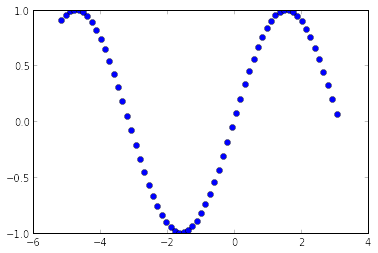

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

x, dx = np.linspace(-3*np.pi / 2 - .5 , np.pi ,num=64, retstep = True, endpoint = False)
x += 0.5*dx # cell-centered grid
f = np.sin(x)

plt.plot(x,f,  'o',lw = 2)


Generate weights and try to extrapolate to one value to the left

In [29]:
from scipy.misc import factorial

def compute_extrapolation_weights(m, S):
    """
    j = weight index ranging from -S, -S+1, ... , S+1, S
    S = stencil half-width
    
    decomposes j into j = -S + m, then computes 
    and returns the jth weight
    """
    return (-1.) ** m / (float(factorial(m)) * (m+1)) * factorial(2*S  + 1) / factorial(2*S-m)
    

def extrapolate_left(S, func, x, dx, iL = 0):
    """
    VERBOSE -- outputs calculations so we can check the implementation
    
    extrapolates one point to the left of the selected point iL
    
    returns a verbose output that shows the calculated weights
    and also the solution and compares it to the exact given a passed function object func
    for given data x with step size dx
    
    the half-width of the stencil is S
    """
    assert( type(S) == int)
    
    f = func(x)
    
    w = np.zeros(2*S+1)
    print "the extrapolation weights for a LTE order %d extrapolation:" % (2*S+1)
    print "----------------------------------------------------------------------\n"
    for m in range(2*S+1):    
        w[m] = compute_extrapolation_weights(m,S)
        print "w[%d] = %g" % (m, w[m])
    

    f_extrap = 0
    for m in range(2*S+1):
        f_extrap += w[m]*f[iL + m]
    print "\nextrapolating one point to the left of $x = %g gives f(%g) = %g" % (x[0], x[0] - dx, f_extrap)
    
    f_exact = func(x[0]-dx)
    print "\n actual value f(x[0]-dx) = %g" % f_exact
    
    print "\n|f_extrap - f_exact| / f_exact = %g %%" % ((f_exact - f_extrap) / f_exact * 100)
    
    return None

In [30]:
extrapolate_left(S = 1, func = np.sin, x = x, dx = dx)

the extrapolation weights for a LTE order 3 extrapolation:
----------------------------------------------------------------------

w[0] = 3
w[1] = -3
w[2] = 1

extrapolating one point to the left of $x = -5.14712 gives f(-5.27765) = 0.843645

 actual value f(x[0]-dx) = 0.844446

|f_extrap - f_exact| / f_exact = 0.0949064 %


<hr>

Try a larger stencil, $S = 2$

In [10]:
extrapolate_left(S = 2, func = np.sin, x = x, dx = dx)

the extrapolation weights for a LTE order 5 extrapolation:
----------------------------------------------------------------------

w[0] = 5
w[1] = -10
w[2] = 10
w[3] = -5
w[4] = 1

extrapolating one point to the left of $x = -5.14712 gives f(-5.27765) = 0.844455

 actual value f(x[0]-dx) = 0.844446

|f_extrap - f_exact| / f_exact = -0.00105828 %


<hr>

And $S = 3$ as we intend to use

In [11]:
extrapolate_left(S = 3, func = np.sin, x = x, dx = dx)

the extrapolation weights for a LTE order 7 extrapolation:
----------------------------------------------------------------------

w[0] = 7
w[1] = -21
w[2] = 35
w[3] = -35
w[4] = 21
w[5] = -7
w[6] = 1

extrapolating one point to the left of $x = -5.14712 gives f(-5.27765) = 0.844446

 actual value f(x[0]-dx) = 0.844446

|f_extrap - f_exact| / f_exact = 8.23135e-06 %


This checks out fine for this example, we try other examples as well now, say a linear trend:

## model data linear: $f(x) = 2x$

In [12]:
def linear(x, a = 2., b = 0.):
    """
    linear function of form y = ax + b
    """
    
    return a*x + b

extrapolate_left(S = 3, func = linear, x = x, dx = dx)

the extrapolation weights for a LTE order 7 extrapolation:
----------------------------------------------------------------------

w[0] = 7
w[1] = -21
w[2] = 35
w[3] = -35
w[4] = 21
w[5] = -7
w[6] = 1

extrapolating one point to the left of $x = -5.14712 gives f(-5.27765) = -10.5553

 actual value f(x[0]-dx) = -10.5553

|f_extrap - f_exact| / f_exact = 8.41452e-13 %


## data generated from $f = \exp (x)$

In [13]:
extrapolate_left(S = 3, func = np.exp, x = x, dx = dx)

the extrapolation weights for a LTE order 7 extrapolation:
----------------------------------------------------------------------

w[0] = 7
w[1] = -21
w[2] = 35
w[3] = -35
w[4] = 21
w[5] = -7
w[6] = 1

extrapolating one point to the left of $x = -5.14712 gives f(-5.27765) = 0.00510439

 actual value f(x[0]-dx) = 0.00510439

|f_extrap - f_exact| / f_exact = -0.000102462 %


Compare with a lower order extrapolation

In [14]:
extrapolate_left(S = 1, func = np.exp, x = x, dx = dx)

the extrapolation weights for a LTE order 3 extrapolation:
----------------------------------------------------------------------

w[0] = 3
w[1] = -3
w[2] = 1

extrapolating one point to the left of $x = -5.14712 gives f(-5.27765) = 0.00511823

 actual value f(x[0]-dx) = 0.00510439

|f_extrap - f_exact| / f_exact = -0.271081 %


## extrapolating more than one point to the left of grid data

we now loop through the routine to extrapolate as many points as we want (we do not want to do too many). We choose S = 3 (7th order LTE extrapolation). This is done easily by looping through the same routine and using each new extrapolation point in the stencil to find the next. We walk through the procedure in detail below, then generalize it:

We iterate through the equation

$$f(x_{i_L-1}) = \sum_{m = 0}^{2S} (-1)^m w_mf(x_{i_L + m}) = \sum_{m=0}^{2S} {2S+1\choose m+1} f(x_{m})$$

where for each successive extrapolation, $i_L = i_L(g)$ where $g = 0, 1, \ldots N_G-1$ the ghost cell $g = 0$ is the closest, $g = N_G-1$ is the furthest.

In 0-based indexed objects on a computer, we have no negative indices. Thus, in order to extend known grid data of size $N_x$ by $N_G$ ghost points on the left, we should create an $N_x + N_G$ array object, store the known data from indices $i = N_G$ to $i = N_G +  N_x - 1$, and fill in ghost points from $i = 0$ to $i = N_G-1$. In practice, we start with the closest ghost point which is at $i = N_G-1$ ($g = 0$) and continue on leftward.  

To extrapolate the first ghosat point at $i = N_G - 1$ w euse  the $(2S+1)$ weights $w_m$ on function data at points $i_L = N_G$ to $i = N_G + (2S+1)$, this convext combination gives us the extrapolated value at the first ghost point $i = (N_G - 1) - 0$. Next, we want to compute the next ghost point at $i = (N_G-1) - 1 = N_G-2$, and we would like to shift our extrapolation stencil to now include the previous (first) ghost point we extrapolated at $i = N_G-1$, thus $i_L = N_G-1$ now. We extrapolate this value, then move onto extrapolating value $i = (N_G-1)-2$ where we would take the left edge of our data stencil to includeextrapolating two ghost points, beginning at $i_L = (N_G-1) - 1$ and extending rightward so that in total we sample the stencil size $(2S+1)$ points, and so on.

We can see in general for a leftward extrapolation, the left edge of data $i_L$ is given by

$$\text{To extrapolating the value } f(x_{i_L-1}) \text{ we sample } (2S+1) \text{ data points at and to the right of the index } \boxed{i_L = N_G-g},\qquad \text{ for ghost cell index } g = 0, 1, 2, \ldots , N_G-1 $$

### <code>compute_extrapolation_weights</code> (revised) 

In [60]:
import sympy

def compute_extrapolation_weights(S, m):
    """
    S = stencil half-width

    returns the mth weight 
    
    """
    
    return  (-1.) ** m  * sympy.binomial(2*S+1, m+1)

### <code>extrapolate_left</code> (input parameter is data, not function object; outputs an extended array of data)

In [16]:
def extrapolate_left(f_ext, f_data, x, dx, NG, order):
    """
    extrapolates one point to the left
    
    inputs:
    f_ext  -- (ndarray, ndim = 1) container of ZEROS whose size = (NG + len(f_data)), where NG = number of ghost points
    f_data -- (ndarray, ndim = 1) data to be used for extrapolation
    x      -- (ndarray, ndim = 1) abscissa
    dx     -- (float)  grid spacing width, each point (including ghost points) are dx apart
    NG     -- (int) number of ghost points needed
    order  -- (int) LTE order of extrapolation, in previous language this was 's', for s odd, order = 2*S+1
    
    outputs:
    f_ext  -- (ndarray, ndim=1) first NG gridpoints are extrapolated values, next len(f_data) 
               points are the entries of f_data   
    
    """
    assert( order % 2 != 0)
    
    S = order // 2
    w = np.zeros(2*S+1)
    print "printing weights w_m for reference:\n"
    for m in range(2*S+1):    
        w[m] = compute_extrapolation_weights(S, m) 
        print w[m]

    print "\n"
    # fill non-ghost entries [NG:] with data
    f_ext[NG:] = f_data
    print "function data has been shifted on an extended grid to be between indices i = %d and i = %d" % (NG, len(f_ext) -1)
    print "\n"
    
    print "ghost points are then at indices (note: the lower the index, the further left it is of the above grid data)"
    for i in range(NG):
        print i
    print '\n'
    # fill in ghost values one-by-one, starting with the closest and moving outward
    for g in range(NG):
        print "for ghost point gp = %d\n" % (NG-g-1)
        for m in range(2*S+1): # m = 0, 1, ... , 2S, 2S+1 terms total, each m has (2S+1)-1 = 2S terms
                               # thus the degree of polynomial is 2S
                
            iL = NG-g # current left edge of known data (extrapolated or otherwise)
            f_ext[iL-1] += w[m] * f_ext[iL+m]
            print "f_ext[%d -1 + %d] += f_ext[%d] = w[%d] * f_ext[%d]" % (iL, g, iL-1+g,m,iL+m)
            
    return f_ext

In [17]:
import numpy as np

x, dx = np.linspace(-3*np.pi / 2 - .5 , np.pi ,num=64, retstep = True, endpoint = False)
x += 0.5*dx # cell-centered grid

f_data = np.sin(x)

NG, order = 2, 5
f_ext = np.zeros(len(f_data) + NG)

f_ext = extrapolate_left(f_ext, f_data, x, dx, NG, order)

print "\nthis creates the extended (on the left) grid data, f_ext ="
print f_ext

printing weights w_m for reference:

5.0
-10.0
10.0
-5.0
1.0


function data has been shifted on an extended grid to be between indices i = 2 and i = 65


ghost points are then at indices (note: the lower the index, the further left it is of the above grid data)
0
1


for ghost point gp = 1

f_ext[2 -1 + 0] += f_ext[1] = w[0] * f_ext[2]
f_ext[2 -1 + 0] += f_ext[1] = w[1] * f_ext[3]
f_ext[2 -1 + 0] += f_ext[1] = w[2] * f_ext[4]
f_ext[2 -1 + 0] += f_ext[1] = w[3] * f_ext[5]
f_ext[2 -1 + 0] += f_ext[1] = w[4] * f_ext[6]
for ghost point gp = 0

f_ext[1 -1 + 1] += f_ext[1] = w[0] * f_ext[1]
f_ext[1 -1 + 1] += f_ext[1] = w[1] * f_ext[2]
f_ext[1 -1 + 1] += f_ext[1] = w[2] * f_ext[3]
f_ext[1 -1 + 1] += f_ext[1] = w[3] * f_ext[4]
f_ext[1 -1 + 1] += f_ext[1] = w[4] * f_ext[5]

this creates the extended (on the left) grid data, f_ext =
[ 0.76760175  0.84445536  0.90698189  0.95408582  0.98495678  0.99906954
  0.99618398  0.97634919  0.93990265  0.88746445  0.8199268   0.73843879
  0.64438687  0.5

<b>Note</b>: due to 0-based indexing precluding us from conveniently using negative indices (which have a very different meaning in python, and no meaning in C), we see from the above that implementation-wise we 

    (1) displace the function data by NG points from the left, f_ext[NG:] = f_data
    (2) ghost points are filled from f_ext[0:NG-1], where the highest ghost index NG-1 corresponds
        to data just one width left of the first point in f_data[0] = f_ext[NG]
       

Actual value at ghost points (compare with the above array's first and second entries):

In [18]:
x_ghost = np.zeros(NG)
for g in range(1,NG+1):
    x_ghost[NG-g] = x[0] - g*dx
f_exact_ghost = np.sin(x_ghost)

print f_exact_ghost

[ 0.76754343  0.84444643]


Difference between extrapolated and exact values:

In [19]:
for g in range(NG):
    print "ghost point g = %d: (f_extrap - f_exact) / f_exact = %g %%" % (g, ((f_ext[g] - f_exact_ghost[g]) / f_exact_ghost[g] * 100))

ghost point g = 0: (f_extrap - f_exact) / f_exact = 0.00759808 %
ghost point g = 1: (f_extrap - f_exact) / f_exact = 0.00105828 %


We try to extraolate 5 values and see how we fare

In [20]:
import numpy as np

x, dx = np.linspace(-3*np.pi / 2 - .5 , np.pi ,num=64, retstep = True, endpoint = False)
x += 0.5*dx # cell-centered grid

f_data = np.sin(x)

NG, order = 5, 5
f_ext = np.zeros(len(f_data) + NG)

f_ext = extrapolate_left(f_ext, f_data, x, dx, NG, order)

printing weights w_m for reference:

5.0
-10.0
10.0
-5.0
1.0


function data has been shifted on an extended grid to be between indices i = 5 and i = 68


ghost points are then at indices (note: the lower the index, the further left it is of the above grid data)
0
1
2
3
4


for ghost point gp = 4

f_ext[5 -1 + 0] += f_ext[4] = w[0] * f_ext[5]
f_ext[5 -1 + 0] += f_ext[4] = w[1] * f_ext[6]
f_ext[5 -1 + 0] += f_ext[4] = w[2] * f_ext[7]
f_ext[5 -1 + 0] += f_ext[4] = w[3] * f_ext[8]
f_ext[5 -1 + 0] += f_ext[4] = w[4] * f_ext[9]
for ghost point gp = 3

f_ext[4 -1 + 1] += f_ext[4] = w[0] * f_ext[4]
f_ext[4 -1 + 1] += f_ext[4] = w[1] * f_ext[5]
f_ext[4 -1 + 1] += f_ext[4] = w[2] * f_ext[6]
f_ext[4 -1 + 1] += f_ext[4] = w[3] * f_ext[7]
f_ext[4 -1 + 1] += f_ext[4] = w[4] * f_ext[8]
for ghost point gp = 2

f_ext[3 -1 + 2] += f_ext[4] = w[0] * f_ext[3]
f_ext[3 -1 + 2] += f_ext[4] = w[1] * f_ext[4]
f_ext[3 -1 + 2] += f_ext[4] = w[2] * f_ext[5]
f_ext[3 -1 + 2] += f_ext[4] = w[3] * f_ext[6]
f_ext[3 -

In [21]:
x_ghost = np.zeros(NG)
for g in range(1,NG+1):
    x_ghost[NG-g] = x[0] - g*dx
f_exact_ghost = np.sin(x_ghost)

print f_exact_ghost

[ 0.46479848  0.57609075  0.67758132  0.76754343  0.84444643]


In [22]:
print "starting from closest (g = -1) and moving outward (g < -1)"
for g in range(1,NG+1):
    print "ghost point g = %d: (f_extrap - f_exact) / f_exact = %g %%" % (-g, ((f_ext[NG-g] - f_exact_ghost[NG-g]) / f_exact_ghost[NG-g] * 100))

starting from closest (g = -1) and moving outward (g < -1)
ghost point g = -1: (f_extrap - f_exact) / f_exact = 0.00105828 %
ghost point g = -2: (f_extrap - f_exact) / f_exact = 0.00759808 %
ghost point g = -3: (f_extrap - f_exact) / f_exact = 0.0325171 %
ghost point g = -4: (f_extrap - f_exact) / f_exact = 0.109374 %
ghost point g = -5: (f_extrap - f_exact) / f_exact = 0.325239 %


So the extrapolation, of course, performs worse the more ghost points we try to extrapolate. We intend on using 3 ghost cells.

### Revised <code>extrapolate_left</code> routine

The above is a direct and poor way of implementing the routine. We spruce it up below:

### <code>extrapolate_left</code> revised

In [23]:
def extrapolate_left(f_ext, f_data, x, dx, NG, order):
    """
    extrapolates one point to the left
    
    inputs:
    f_ext  -- (ndarray, ndim = 1) container of ZEROS whose size = (NG + len(f_data)), where NG = number of ghost points
    f_data -- (ndarray, ndim = 1) data to be used for extrapolation
    x      -- (ndarray, ndim = 1) abscissa
    dx     -- (float)  grid spacing width, each point (including ghost points) are dx apart
    NG     -- (int) number of ghost points needed
    order  -- (int) ODD order of extrapolation, in previous language this was 's'
    
    outputs:
    f_ext  -- (ndarray, ndim=1) first NG gridpoints are extrapolated values, next len(f_data) 
               points are the entries of f_data   
    
    """
    assert( order % 2 != 0)
    
    stencil_size = order
    S = order // 2
    w = np.zeros(2*S+1)
    for m in range(stencil_size):    
        w[m] = compute_extrapolation_weights(S, m) 

    # fill non-ghost entries [NG:] with data
    f_ext[NG:] = f_data

    # fill in ghost values one-by-one, starting with the closest and moving outward
    for g in range(NG):
        ip = NG - g # current left edge of known data, i.e. f[ip] is known
        f_ext[ip-1] = w.dot(f_ext[ip:ip+stencil_size]) # [start:stop], start = ip,  stop = start + stencil_size -1
            
    return f_ext

In [24]:
import numpy as np

x, dx = np.linspace(-3*np.pi / 2 - .5 , np.pi ,num=64, retstep = True, endpoint = False)
x += 0.5*dx # cell-centered grid

f_data = np.sin(x)

NG, order = 5, 5
f_ext = np.zeros(len(f_data) + NG)

f_ext = extrapolate_left(f_ext, f_data, x, dx, NG, order)

x_ghost = np.zeros(NG)
for g in range(1,NG+1):
    x_ghost[NG-g] = x[0] - g*dx
f_exact_ghost = np.sin(x_ghost)

print f_exact_ghost

print "starting from closest (g = -1) and moving outward (g < -1)"
for g in range(1,NG+1):
    print "ghost point g = %d: (f_extrap - f_exact) / f_exact = %g %%" % (-g, ((f_ext[NG-g] - f_exact_ghost[NG-g]) / f_exact_ghost[NG-g] * 100))

[ 0.46479848  0.57609075  0.67758132  0.76754343  0.84444643]
starting from closest (g = -1) and moving outward (g < -1)
ghost point g = -1: (f_extrap - f_exact) / f_exact = 0.00105828 %
ghost point g = -2: (f_extrap - f_exact) / f_exact = 0.00759808 %
ghost point g = -3: (f_extrap - f_exact) / f_exact = 0.0325171 %
ghost point g = -4: (f_extrap - f_exact) / f_exact = 0.109374 %
ghost point g = -5: (f_extrap - f_exact) / f_exact = 0.325239 %


Which agrees with the result above.

# Extrapolate right routine

The reader can verify the result for extrapolating to the right by one width $\Delta x$, is given by:

$$\boxed{f(x_{i+S+1}) = \sum_{j=-S}^S w_j f(x_{i+j})}$$

where $$\boxed{w_j = (-1)^{S+j}{2S+1 \choose S+j}}, \quad \text{ where } j = -S, -S+1, \ldots , S-1, S$$

or in terms of zero-based indexing and the left-most index of the stencil $i_L$ as used above in the context of left extrapolation:

$$\boxed{f(x_{i_L+S+1}) = \sum_{m=0}^{2S} w_m f(x_{i_L+m})} \quad \Rightarrow \quad \underline{w}_{1\times (2S+1)}\cdot \underline{\hat{f}_{i_L}}_{(2S+1)\times 1} \quad \text{ where } \underline{\hat{f}_{i_L}}_{((2S+1)\times 1} = (f_{x_L}, f_{x_L+1}, f_{x_L+2}, \ldots f_{x_L+(2S+1)})^T$$

where $i_L$ is the left edge of the stencil and $w_m = (-1)^m{2S+1 \choose m}$

or, in terms of $i_R$ the right-edge of the data we can index negatively:

$$f(x_{i_R+1}) = \sum_{m=-2S}^{0} w_m f(x_{i_R+m})$$

or if we want to use positive indexing:

$$f(x_{i_R+1}) = \sum_{m=0}^{2S} w_m f(x_{i_R+2S-m})$$

but this is only useful in a looping context where negative indexes is not permitted (e.g. C implementation). If we use dot products, it is more natural to use the form in terms of $i_L$ as shown in the second form above.

#### Procedure for extrapolating more than one point to the right

Let us take the context of extrapolating only points to the right adn returning an extended array with $N_G$ ghost points on the right hand side, since we are considering no ghost points on the left, we do not require displacing the grid data in the extended array object of size $N_x + N_G$, but rather just figuring out the values that go at point $i = N_x$ to $i = N_x + N_G -1$. Later we generalize this to include cases where we have ghost points on the left and right, this changes the below framework by just an offset of the number of ghost cells on the left, we will get to this after this section. 

It is most useful to perform the sums as dot products and to identify the left edge of a data stencil, $i_L = i_R - (2S+1)$ where $i_L = i_L(g)$ and $i_R = i_R(g)$ depend on $g = 0, 1, 2, \ldots N_G-1$ and depend on the current information (extrapolated or non) since we extrapolate one point at a time and the stencil will use all points left of the ghost point in question, thus in a succession of extrapolations, previous ghost points are employed as part of the stencils (as well as possibly grid data) as the ghost points get further and further away from the known data. 

First we calculate the extrapolated value for the ghost point at $i = N_x$, where the right edge of the stencil being $i_R = N_x-1 + 0$ and we sample leftward so that in total we sample ($2S+1$) points. After we calculated the extrapolation for $i = N_x$ we move onto trying to compute the value at $i = N_x+1$ which samples data with a right edge of the stencil being one point to the right so $i_R = N_x  = (N_x-1) + 1$ and sample points leftward so that in total we sample $2S+1$ points which give us the value at $i = N_x + 1$, moving onto finding the value at $i = N_x+2$ we have $i_R = N_x+1 = (N_x-1)+2$ and so on, thus

$$i_R = (N_x-1) + g, \qquad \text{where the ghosts cell label } g = 0,1 , \ldots N_G-1$$

and

$$i_L = i_R - [(2S+1) + 1]= i_R - 2S$$

Thus, $i_R - i_L + 1 = \text{total number in stencil} = 2S+1$

We test this below for some generated data sets

In [53]:
import sympy

def compute_extrapolation_weights_right(S, m = 0):
    """
    S = stencil half-width
    
    returns the jth weight (equivalently, the m = j + S weight
    
    """
    return (-1.) ** m  * sympy.binomial(2*S+1, m)

For example, if $S = 3$ we have the weights:

In [58]:
S = 3
print "for extrapolating to the right...\n"
for m in range(2*S+1):
    w = compute_extrapolation_weights_right(S, m)
    print "w_%d = %g" % (m, w)

for extrapolating to the right...

w_0 = 1
w_1 = -7
w_2 = 21
w_3 = -35
w_4 = 35
w_5 = -21
w_6 = 7


Compared with the weights at the left edge, we had

In [61]:
S = 3
print "for extrapolating to the left...\n"
for m in range(2*S+1):
    w = compute_extrapolation_weights(S, m)
    print "w_%d = %g" % (m, w)

for extrapolating to the left...

w_0 = 7
w_1 = -21
w_2 = 35
w_3 = -35
w_4 = 21
w_5 = -7
w_6 = 1


<font color = "purple">This is always the case that these two stencils are the reverse of each other. We actually do not need two routines for left vs. right for computing the weights, we just compute one direction and the weights for the other are the reverse.</font>

Thus we can see we get the anticipated reverse depending on which side are extrapolating on.

In [68]:
def extrapolate_right(f_ext, f_data, x, dx, NG, order):
    """
    extrapolates one point to the left
    
    inputs:
    f_ext  -- (ndarray, ndim = 1) container of ZEROS whose size = (NG + len(f_data)), where NG = number of ghost points
    f_data -- (ndarray, ndim = 1) data to be used for extrapolation
    x      -- (ndarray, ndim = 1) abscissa
    dx     -- (float)  grid spacing width, each point (including ghost points) are dx apart
    NG     -- (int) number of ghost points needed
    order  -- (int) ODD LTE order of extrapolation
    
    outputs:
    f_ext  -- (ndarray, ndim=1) first NG gridpoints are extrapolated values, next len(f_data) 
               points are the entries of f_data   
    
    """
    assert( order % 2 != 0)
    
    Nx = len(f_data)
    S = order // 2
    stencil_size = order
    
    w = np.zeros(stencil_size)
    print "printing computed weights for reference, degree of extrapolant = %d" % degree
    for m in range(stencil_size):    
        w[m] = compute_extrapolation_weights_right(S, m) 
        print w[m]

    # fill non-ghost entries [:-NG] with data, i.e. entries i = 0, 1, 2, ... , -NG-1
    f_ext[:Nx] = f_data

    # fill in ghost values one-by-one, starting with the closest and moving outward
    for g in range(NG):
        iR = Nx -1 + g #  current right edge of data, i.e. f[iR] is known
        iL = iR - (stencil_size-1)
        f_ext[iR+1] = w.dot(f_ext[iL:iR+1]) 
        
        # NOTE: we are purposefuly not using negative indexing as we intend to Cythonize this
            
    return f_ext

In [66]:
import numpy as np

x, dx = np.linspace(-3*np.pi / 2 - .5 , np.pi ,num=64, retstep = True, endpoint = False)
x += 0.5*dx # cell-centered grid

f_data = np.sin(x)

NG, order = 5, 7
f_ext = np.zeros(len(f_data) + NG)

f_ext = extrapolate_right(f_ext, f_data, x, dx, NG, order)

x_ghost = np.zeros(NG)
for g in range(NG):
    x_ghost[g] = x[-1] + (g+1)*dx
    
f_exact_ghost = np.sin(x_ghost)

print "\nstarting from closest (g = 0) and moving outward (g > 0)"
for g in range(NG):
    print "ghost point g = %d: (f_extrap - f_exact) / f_exact = %g %%" % (g, ((f_ext[-NG+g] - f_exact_ghost[g]) / f_exact_ghost[g] * 100))

printing computed weights for reference, degree of extrapolant = 4
1.0
-7.0
21.0
-35.0
35.0
-21.0
7.0

starting from closest (g = 0) and moving outward (g > 0)
ghost point g = 0: (f_extrap - f_exact) / f_exact = 0.00091049 %
ghost point g = 1: (f_extrap - f_exact) / f_exact = 0.00245563 %
ghost point g = 2: (f_extrap - f_exact) / f_exact = 0.00674073 %
ghost point g = 3: (f_extrap - f_exact) / f_exact = 0.0164034 %
ghost point g = 4: (f_extrap - f_exact) / f_exact = 0.0360539 %


printing computed weights for reference, degree of extrapolant = 4
1.0
-7.0
21.0
-35.0
35.0
-21.0
7.0


[3.6, 3.8, -0.6, -0.4]

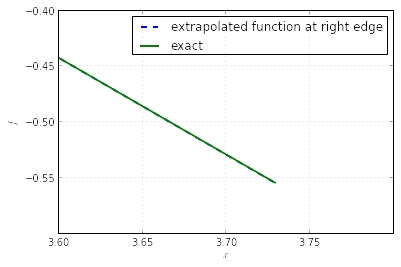

In [67]:
%matplotlib inline

import matplotlib.pyplot as plt

x, dx = np.linspace(-3*np.pi / 2 - .5 , np.pi ,num=64, retstep = True, endpoint = False)
x += 0.5*dx # cell-centered grid

f_data = np.sin(x)

NG, order = 5, 7
f_ext = np.zeros(len(f_data) + NG)
f_ext = extrapolate_right(f_ext, f_data, x, dx, NG, order)

# compare with exact on extended grid

x_ext = np.zeros(len(x) + NG)
x_ext[:-NG] = x
for g in range(NG):
    x_ext[-NG+g] = x[-1] + (g+1)*dx

    
f_exact_ext_right = np.sin(x_ext)

plt.plot(x_ext,f_ext, '--', lw = 2, label = 'extrapolated function at right edge')
plt.plot(x_ext, f_exact_ext_right, lw = 2, label = 'exact')
plt.grid()
plt.legend(loc = 'best')
plt.xlabel(r'$x$')
plt.ylabel(r'$f$')
plt.axis([3.6, 3.8, -.6, -.4])

Note, this is actually quite far away from the last $x$ data, which is at $x = \pi$, so we have extrapolated quite far beyond where we should ideally. If we redo the above we can show safer extrapolation practices, here we had

In [48]:
print dx

0.130530963031


a large width $\Delta x \sim 0.1303\ldots $.

#### Redoing the right extrapolation by 5 points when $\Delta x$ smaller

printing computed weights for reference, degree of extrapolant = 4
1.0
-7.0
21.0
-35.0
35.0
-21.0
7.0
g = 0, NG = 5
g = 1, NG = 5
g = 2, NG = 5
g = 3, NG = 5
g = 4, NG = 5


[3.0600108016955101, 3.3210727277572141, -0.2, 0.1]

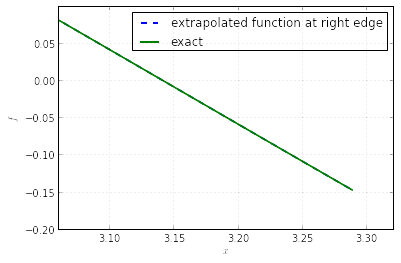

In [50]:
%matplotlib inline

import matplotlib.pyplot as plt

x, dx = np.linspace(-3*np.pi / 2 - .5 , np.pi ,num=256, retstep = True, endpoint = False)
x += 0.5*dx # cell-centered grid

f_data = np.sin(x)

NG, order = 5, 7
f_ext = np.zeros(len(f_data) + NG)
f_ext = extrapolate_right(f_ext, f_data, x, dx, NG, order)

# compare with exact on extended grid

x_ext = np.zeros(len(x) + NG)
x_ext[:-NG] = x
for g in range(NG):
    x_ext[-NG+g] = x[-1] + (g+1)*dx

    
f_exact_ext_right = np.sin(x_ext)

plt.plot(x_ext,f_ext, '--', lw = 2, label = 'extrapolated function at right edge')
plt.plot(x_ext, f_exact_ext_right, lw = 2, label = 'exact')
plt.grid()
plt.legend(loc = 'best')
plt.xlabel(r'$x$')
plt.ylabel(r'$f$')
plt.axis([x[-3], x_ext[-1]+dx, -.2, .1])

Which is much better, we can measure how much again by pasting the same commands from above:

In [69]:
import numpy as np

x, dx = np.linspace(-3*np.pi / 2 - .5 , np.pi ,num=256, retstep = True, endpoint = False)
x += 0.5*dx # cell-centered grid

f_data = np.sin(x)
NG, order = 5, 7
f_ext = np.zeros(len(f_data) + NG)
f_ext = extrapolate_right(f_ext, f_data, x, dx, NG, order)
x_ghost = np.zeros(NG)
for g in range(NG):
    x_ghost[g] = x[-1] + (g+1)*dx
    
f_exact_ghost = np.sin(x_ghost)

print "\nstarting from closest (g = 0) and moving outward (g > 0)"
for g in range(NG):
    print "ghost point g = %d: (f_extrap - f_exact) / f_exact = %g %%" % (g, ((f_ext[-NG+g] - f_exact_ghost[g]) / f_exact_ghost[-NG+g] * 100))

printing computed weights for reference, degree of extrapolant = 4
1.0
-7.0
21.0
-35.0
35.0
-21.0
7.0

starting from closest (g = 0) and moving outward (g > 0)
ghost point g = 0: (f_extrap - f_exact) / f_exact = 2.40133e-07 %
ghost point g = 1: (f_extrap - f_exact) / f_exact = 6.40929e-07 %
ghost point g = 2: (f_extrap - f_exact) / f_exact = 1.73245e-06 %
ghost point g = 3: (f_extrap - f_exact) / f_exact = 4.13071e-06 %
ghost point g = 4: (f_extrap - f_exact) / f_exact = 8.85029e-06 %


# General routines for either side of <code>compute_extrapolation_weights</code> and <code>extrapolate</code>

The following considers a 1D case, we will generalize this in a later section.

we make the following notes:

    (1) An extrapolation routine (of either side, left or right) does not need access to the full set of data, 
        but rather only 2S+1 points of known grid data maximum
    
    (2) A python orchestrator can be used in tandem with a Cython extrapolation routine as follows:
    
            o in the orchestrator --
              initialize an extended array of zeros, f_ext, of dimension Nx + NGL + NGR , where NGL an NGR are the 
              number of ghost cells on the left and right
              
            o if NGL != 0: pass an abbreviated data set + container f_GL, of size NGL + (2S+1)
                
                where f_GL[2S+1:] = f[:2S+1], and f_GL[:NGL] = 0 (ghost points to be filled in by extrap)
                
                    return f_GL

            o if NGR != 0: pass an abbreviated data set + container f_GR, of size NGR + (2S+1)
                
                where f_GR[:2S+1] = f[-2S:], and f_GR[2S+1:] = 0 (ghost points to be filled in by extrap)
                
                    return f_GR
                  
            o python orchestrator fills in f_ext[:NGL] = f_GL, f_ext[NGL:Nx+NGR] = f, f_ext[Nx+NGR:] = f_GR

    OR

    (3) we can make one Cython routine and pass f, f_ext and extrapolate both sides
    
    it should considered which one is more efficient for intended grid sizes. The item (2) method is more 
    cumbersome but has the benefit of object handling smaller arrays, the item (3) method handles
    larger objects but has the benefit of evading extra array lookups/assignments which are required
    in the final steps of item (2) which is left to the orchestrator to index slice and consolidate data.
    numpy array lookups can be quite slow as compared to C array lookups, it is thought item (3) is better 
    but this will be investigated below.

In [347]:
import sympy

def compute_extrapolation_weights(S, j = None, boundary = 'lower'):
    """
    
    inputs:
    S -- (int) stencil half-width. For a given extrapolating polynomial EVEN degree, S = degree / 2
    j -- (int) stencil index, measured relative to the stencil center
    boundary -- (str) 'lower' or 'upper', indicates direction of extrapolation
    
    outputs:
    wj -- (float) extrapolation weight w_j, where j = -S + m, m = 0, 1, ... , 2S
    
    """     

    if boundary == 'lower':   wj = (-1.) ** (j+S)  * sympy.binomial(2*S+1, j+S+1)
    elif boundary == 'upper': wj = (-1.) ** (j+S)  * sympy.binomial(2*S+1, j+S)
    
    return wj

In an implementation, the grid <code>f_ext</code> will have been generated already and it will be known which boundaries we require extrapolating, hence we do not create the object <code>f_ext</code> inside the extrapolation but instead just fill it with values.



In [ ]:
def extrapolate(f_ext, f_data, x, dx, NG, degree, w, boundary = 'lower'):
    """
    extrapolates one point to the left
    
    inputs:
    f_ext  -- (ndarray, ndim = 1) container of ZEROS whose size = (NG + len(f_data)), where NG = number of ghost points
    f_data -- (ndarray, ndim = 1) data to be used for extrapolation
    x      -- (ndarray, ndim = 1) abscissa
    dx     -- (float)  grid spacing width, each point (including ghost points) are dx apart
    NG     -- (int) number of ghost points needed
    degree  -- (int) EVEN order of extrapolation, in previous language this was 's-1', S = degree / 2
    
    outputs:
    f_ext  -- (ndarray, ndim=1) first NG gridpoints are extrapolated values, next len(f_data) 
               points are the entries of f_data   
    
    """
    assert( degree % 2 == 0)
    
    S = degree / 2
    w = np.zeros(2*S+1)

    # fill non-ghost entries [:-NG] with data
    f_ext[:-NG] = f_data

    # fill in ghost values one-by-one, starting with the closest and moving outward
    for g in range(NG):
        print "g = %d, NG = %d" % (g, NG)
        stop = -NG+g # one grid point beyond stencil, negative indexing
        start = stop - (2*S + 1) # start of stencil, negative indexing
        
        f_ext[-NG+g] = w.dot(f_ext[start:stop]) # [start:stop], start = NG+g+1, stop = start + 2S+1
            
    return f_ext

In [353]:
NGL, NGR = 3, 3 # number of ghost cells on left, right

Nx = len(f_data)
N_ext = NGL + NGR + Nx

f_ext = np.zeros(N_ext)

boundary = 'lower' # dummy value so that code can be unit tested
if boundary == 'upper':
    wR = np.zeros(2*S + 1)
    print "printing computed weights for reference, degree of right extrapolant = %d" % degree
    for j in range(-S, S+1):    
        wR[S+j] = compute_extrapolation_weights(S, j = j, boundary = 'upper') 
        print wR[S+j]

elif boundary == 'lower':
    wL = np.zeros(2*S + 1)
    print "printing computed weights for reference, degree of left extrapolant = %d" % degree
    for j in range(-S, S+1):    
        wL[S+j] = compute_extrapolation_weights(S, j = j, boundary = 'lower') 
        print wL[S+j]



printing computed weights for reference, degree of left extrapolant = 4
5.0
-10.0
10.0
-5.0
1.0
